In [1]:
from pathlib import Path
import tomli
import numpy as np
import jax
import jax.random as jr
from jaxlinop import identity
from jaxutils import Dataset
from geometric_asymptotics.io import load_space
from geometric_asymptotics.experiment import generate_kernel_and_training_data, compute_predictions, compute_extrinsic_length_scale, compute_non_asymptotic_expected_error
from geometric_asymptotics.plot_mpl import plot_kernel, plot_data, plot_errors
from geometric_asymptotics.plot_pl import plot_mesh
from geometric_asymptotics.utils import batch_predict_mean, batch_predict_variance
jax.config.update("jax_enable_x64", True)

INFO: Using numpy backend


# Load mesh 

Assemble adjacency matrix and graph

In [2]:
with open(Path.cwd() / ".." / "config" / "sphere.toml", "rb") as f:
    config = tomli.load(f)

seed = 0

In [3]:
(mesh,coordinates) = load_space(Path.cwd() / ".." / config["source"])

In [4]:
coordinates.shape

(2562, 3)

# Generate full training data

Generate x-values by sampling random points on the mesh, and y-values by sampling from intrinsic prior

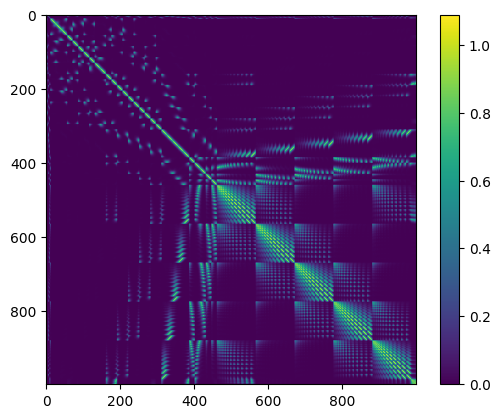

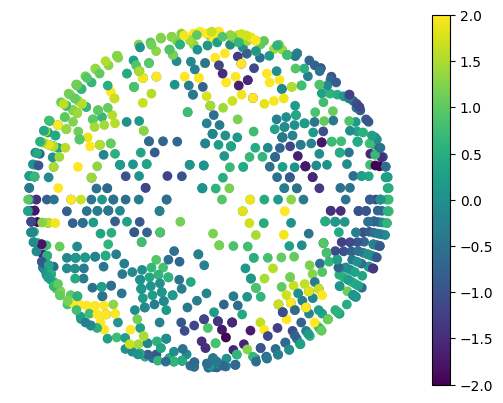

In [5]:
key = jr.PRNGKey(seed)
(k1,key) = jr.split(key)
(kernels, training_data, test_data) = generate_kernel_and_training_data(mesh, coordinates, config, k1)

plot_kernel(kernels[0].gram(kernels[2], test_data[0][:config["num_plot"],:]).to_dense())
plot_data(training_data[1], training_data[2], lims=(-2,2))

# Predictions

For both intrinsic and extrinsic model with a subset of the data points, as a sanity check

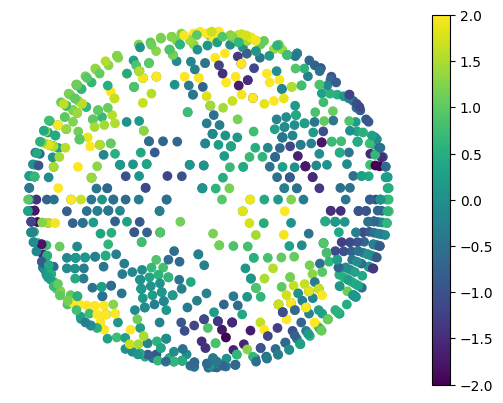

In [6]:
(k2,key) = jr.split(key)
(pred_mean, test_pred_mean, test_pred_var, pred_results) = compute_predictions(kernels, training_data, test_data, config, k2)

plot_data(*pred_mean, lims=(-2,2))

In [ ]:
plot_mesh(mesh, batch_predict_mean(pred_results[1].predict(pred_results[2], pred_results[0]), test_data[0]))

In [ ]:
plot_mesh(mesh, batch_predict_variance(pred_results[1].predict(pred_results[2], pred_results[0]), test_data[0]))

# Extrinsic length scale

Since the extrinsic and intrinsic processes have length scales which are defined only up to some unknown multiplicative constant, we need to find an extrinsic length scale which matches the intrinsic one

In [9]:
(k3,key) = jr.split(key)
kappa_extr, posterior_ls, learned_params_ls = compute_extrinsic_length_scale(kernels, training_data, config, k3)
print("extrinsic optimized length scale:", kappa_extr)

  0%|          | 0/1000 [00:00<?, ?it/s]

extrinsic optimized length scale: 0.3128557199037569


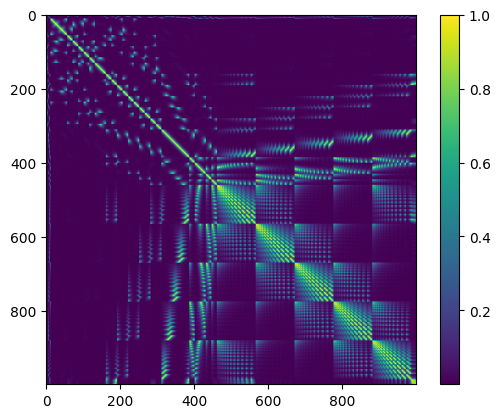

In [10]:
data_ls_matching = Dataset(X=training_data[1][:config["subset_size_int"],:], y=training_data[2][:config["subset_size_int"],:].reshape(-1,1))
plot_kernel(kernels[1].gram(learned_params_ls['kernel'], test_data[1][:config["num_plot"],:]).to_dense())

In [ ]:
plot_mesh(mesh, batch_predict_mean(posterior_ls.predict(learned_params_ls, data_ls_matching), test_data[1]))

In [ ]:
plot_mesh(mesh, batch_predict_variance(posterior_ls.predict(learned_params_ls, data_ls_matching), test_data[1]))

# Non-asymptotic expected error

Finally, we condition on subsets of data, and compute expected error for the two models considered

  0%|          | 0/41 [00:00<?, ?it/s]

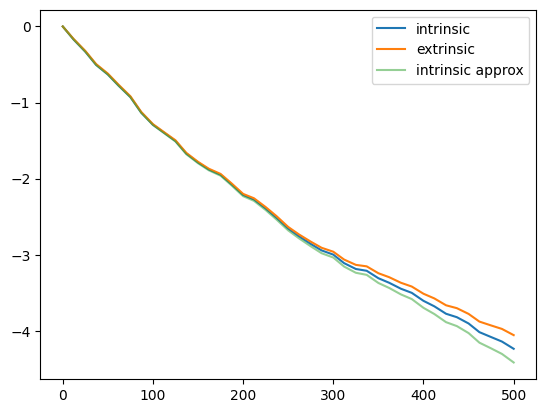

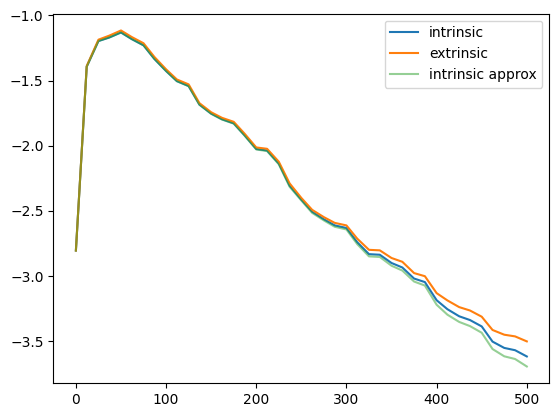

In [13]:
(k4,key) = jr.split(key)
output = compute_non_asymptotic_expected_error(kernels, training_data, test_data, coordinates.shape[0], kappa_extr, config, k4)
plot_errors(output["expected_error_idxs"], output["expected_errors"], output["expected_errors_extr"], output["expected_errors_approx_intr"])
plot_errors(output["expected_error_idxs"], output["expected_errors_std"], output["expected_errors_extr_std"], output["expected_errors_approx_intr_std"])

# Plotting output

This code produces output for the plotting figures in the paper

In [14]:
(k5,k6,key) = jr.split(key,3)
y_sample = (kernels[0].gram(kernels[2], test_data[0]) + identity(coordinates.shape[0]) * config["noise_variance"]).to_root() @ jr.normal(k5, (coordinates.shape[0], 1))
y_sample_extr = (kernels[1].gram(learned_params_ls['kernel'], test_data[1]) + identity(coordinates.shape[0]) * config["noise_variance"]).to_root() @ jr.normal(k6, (coordinates.shape[0], 1))

In [15]:
np.savetxt(Path.cwd() / "output" / "s2_sample_intr.csv", y_sample, delimiter=',')
np.savetxt(Path.cwd() / "output" / "s2_sample_extr.csv", y_sample_extr, delimiter=',')